## Exploring the behaviour of drivers using the Intelligent Driver Model

This essay studies car-following behaviour on a road where overtaking is prohibited. This study uses an Intelligent Driver Model to simulate the rate of change of the velocity (acceleration) of the car-follower and examine how initial gap affects the follower's velocity over time.

### Problem setup

2 cars are driving on a small London road where overtaking is not allowed. The speed limit (V_MAX) is standard for London at 20 miles/h ~ 8.9 m/s (I'm using 10 m/s because typically cars have a 10-20% leeway). 

The lead car driver is moving slowly at 6 meters/s (think a very cautious grandma). How does a newly arriving driver adjust their speed over time if overtaking is prohibited?

Firstly, we should define the modelling equation

The **IDM equation** is the following.


$$\frac{dv_\alpha}{dt} = a(1 - (\frac{v_\alpha}{v_{0}})^\delta - (\frac{s^*(v_\alpha, \Delta v_\alpha)}{s_{\alpha}})^2)$$

Where:

$$s^{*}(v_{\alpha},\Delta v_{\alpha })= s_{0}+v_{\alpha}T+\frac{v_{\alpha }\Delta v_{\alpha}}{2{\sqrt {ab}}}$$

Variables:

$a = 2 \ m/s^2$, which denotes maximum acceleration of vehicle 2

$v_{max} = 10 \ m/s$, about 20 mph

$s_{0} = 2 \ m$ Minimum distance

$T = 2 \ s$ \ `SAFE_TIME_HEADWAY` - 2-second driving rule

$b = 0.5 \ m/s^2$ Comfortable Deceleration

Our code will depend on 3 additional values:

$s(0) = 100 \ m$ `INITIAL_DISTANCE` (initial gap)

$v_2 = 2 \ m/s$

$\Delta v_{\alpha}$ - difference of car velocities, for example: $$2 \ m/s - 6 \ m/s = -4 \ m/s$$

IDM model has 2 components:

$a(1 - (\frac{v_\alpha}{v_{0}})^\delta)$ - the free road component which sets how the driver would behave if it was the lead car, where $\delta$ is the smoothness variable showing how smoothly does the driver adjust his speed, and

$(\frac{s^*(v_\alpha, \Delta v_\alpha)}{s_{\alpha}}^2)$ - the interaction component. It aims to capture how the driver adjust his speed based on how fast the car in front is driving and how wide the gap between cars is. 

Where:

${s^*(v_\alpha, \Delta v_\alpha)}$ - desired distance

$s_{\alpha}$ - actual gap (distance) between leader and follower

### Modelling assumptions

This model assumes that driver does not break the speed limit, 1D motion (no overtaking), and driver reacts instantaneously. Moreover, the lead vehicle dynamics are prescribed and remains constant so we can isolate the follower behaviour. 

### Differential equations 

To simulate the follower car we need a set of functions that describe its motion through time:

- $x_f(t)$ - follower position (m)
- $v_f(t)$ - follower speed (m/s)
- $s(t)$ - gap between leader and follower (m)

We treat the leader as a constant (a modelling assumption) - the lead car drives at constant speed $v(t)=V_{\text{CAR1}}$ so for car 1:

$xL(t)= xL_{0} + V_{\text{CAR1}} * {t}$ - change of position (L means lead car, F means follower)

Therefore: ${\frac{dxL} {dt}} = V_{\text{CAR1}} $ 

For the **car-follower** it becomes more interesting as speed is not constant:

${\frac{dxF}{dt}} = {vF(t)} $ - rate of change of position over time

$s(t) = xL(t) - xF(t)$ - change of the gap between cars

${\Delta v}$ = $vF(t) - vL(t)$ - difference between velocities

Therefore:
$${\frac{ds}{dt}} = vL(t) - vF(t) = -{\Delta v}$$

This is useful because if ${\Delta v} > 0$ the follower speed is greater than lead, following car needs extra distance to successfully brake and avoid collision.

This is accounted in the ${s^*}$ function where $\frac{v_{\alpha }\Delta v_{\alpha}}{2{\sqrt {ab}}}$ is the extra distance we need when closing in on the lead car. $v_{\alpha}T$ is the extra distance we need to have as humans can't react immediately. In my model $T = 2$ because of the common 2-second rule, which states you should be at least two seconds away from a car in front of you based on your current velocity. Additionally, there is a $s_{0} = 2$ term which notes the minimum distance to the next vehicle at all times. $2s$ was chosen because I have asked my dad (as a driver) what is his usual minimum distance he takes at traffic lights and in heavy traffic.

Now that we have defined all the variables and derived the equations we can start simulating the IDM model.

#### Defining constants and importing modules

I have put all my constants in this code section to be easily modified

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# m is meters
# capital letter - constants (initial conditions)
V_MAX = 10 # m/s, a little more than 20 mph
A = 2 # m/s^2 - maximum acceleartion of vehicle 
S_MIN = 2 # m
POWER_DELTA = 4 # smoothness coefficient
V_CAR_1 = 6 # m/s
V_CAR_2 = 2 # m/s
INITIAL_DISTANCE = 100 # m
SAFE_TIME_HEADWAY = 2 #
B = 0.5 # m/s^2

# ====================================================
# v_car_1, a, s_min - program assumes int
# However, python does not have strict types so do whatever you want
# I like them because when calling a function my editor shows what type should I be putting there
# ====================================================


# Simulation parameters
h = 0.01 # step size for euler method
T = 100 # program runtime 

#### Defining functions

Now we will create 3 functions that find $\Delta {v}$, ${s^*}$ and $s$ values

In [31]:
# I know it is technically incorrect to put list[float] it should be just float
# However, this saves me a lot of time so I don't forget

def delta_v(v_following: list[float], v_leading: int = V_CAR_1) -> float:
    """
        v_leading   - speed of first car (const)
        v_following - speed of the second car

        returns: delta_v value
    """
    return v_following - v_leading


def s_star(
        v_following: list[float], v_delta: list[float], 
        s_min: int = S_MIN, a: int = A, b: float = B, sth: float = SAFE_TIME_HEADWAY
    ) -> float:
    """
        s_min (minimum distance to next vehicle)  -   default=2
        a (maximum acceleration speed (m/s^2))    -   default=2
        b (braking acceleration)                 -   default=1/2
        sth (minimum time distance to next car)   -   default=2

            
        v_following - speed of the following car
        v_delta     - calculated in the delta_v function 


        returns: s* value
    """
    return s_min + (sth * v_following) + (v_following * v_delta / (2 * np.sqrt(a * b)))

def distance(dist: list[float], v_delta: list[float], h: float = h) -> float:
    """
        v_following - speed of the following car
        h (0.01)    - step size for euler method
        v_car_1     - speed of leading car (const)

        returns: new distance between vehicles (m)
    """

    if dist - v_delta * h < 0:
        raise ValueError('The cars have collided! BRING THE MEDICS... too late. The intelligent driver is dead.')


    return dist - v_delta * h

#### Setting up the modelling function

I have decided not to take functions as input into the IDM but compute them separately instead, store them in a variable and pass them into the model

In [32]:
# Function for intelligent driving model

def IDM(
        v: list[float], s_dist: list[float], s_star: list[float],
        a = A, v0 = V_MAX, d = POWER_DELTA) -> float:

    return a * (1 - (v/v0) ** d - (s_star/s_dist) ** 2)

#### Numerical method

I will use the Euler method to solve the ODEs. Even though it is less resource-efficient compared to Runge-Kutta methods, due to the small number of cars (2) it is good enough.

The Euler method works by following formula:

$v_{i + 1} = v_i + h * IDM(v_i, s_i, s^*_i)$

The method will update the values for every step $h$ and store them in lists for future analysis.

$h$ was chosen to be 0.01 which is the step size which allows the maximum accuracy to performance ratio.  


In [33]:
def init_program(initial_gap: float):
    # euler method

    # Initialise the t array for h values
    t_list = np.arange(0, T, h)

    # lists to store our data
    # This is all taken from the code we have done in class
    delta_v_values = np.zeros(len(t_list))
    distance_values = np.zeros(len(t_list))
    following_v_values = np.zeros(len(t_list))
    s_star_values = np.zeros(len(t_list))
    position_values = np.zeros(len(t_list))

    # Initial values
    delta_v_values[0] = V_CAR_2 - V_CAR_1
    distance_values[0] = initial_gap
    following_v_values[0] = V_CAR_2
    s_star_values[0] = s_star(following_v_values[0], delta_v_values[0])
    position_values[0] = 0.0 

    dv_dt_values = []
    # starting position of car 2 is 0 (. so it doesn't have some float/int issues)


    for i in range(len(t_list) - 1):
        # find dv/dt and apply to next value

        dv_dt = IDM(following_v_values[i], distance_values[i], s_star_values[i])
        dv_dt_values.append(dv_dt)
        following_v_values[i + 1] = following_v_values[i] + h * dv_dt

        # Update new values so we can call on them to find dv/dt in the next iteration
        delta_v_values[i + 1] = delta_v(following_v_values[i + 1])
        s_star_values[i + 1] = s_star(following_v_values[i + 1], delta_v_values[i + 1])
        distance_values[i + 1] = distance(distance_values[i], delta_v_values[i + 1])
        # S = v*t
        position_values[i + 1] = position_values[i] + following_v_values[i + 1] * h

    values_dict = {
        't': t_list,
        'delta_v': delta_v_values,
        'vF': following_v_values,
        's_star': s_star_values,
        'xF': position_values,
        'gap': distance_values,
        'aF': dv_dt_values
    }


    return values_dict

data = []
gaps = [INITIAL_DISTANCE, 50, 10, 5]
for gap in gaps:
    data.append(init_program(gap))

### Analysis

In this section I will analyse the data derived from the Euler method above, in particular:

how `following_v_values`, `delta_v_values`, `distance_values`, `position_values` change across time

`s_star_values` (desired gap) - with respect to the actual gap.

The simulations show that values converge to a state where $\Delta v$ -> 0, ${\frac{dv} {dt}}$ -> 0, and $s(t)$ -> $s_{0} + v * T$ (since the closing-speed term in $s^*$ vanishes as $\Delta v$ -> 0).

Smaller initial gaps make cars decelerate earlier therefore a faster decrease of $\Delta v$, while larger initial gaps allow an initial acceleration phase as the follower closes the distance before settling to the leader’s speed.

In [34]:
t_list = data[0]['t']

# originally I did not have a function wrapper for the euler so I'll assign this so I don't have to change all my plots

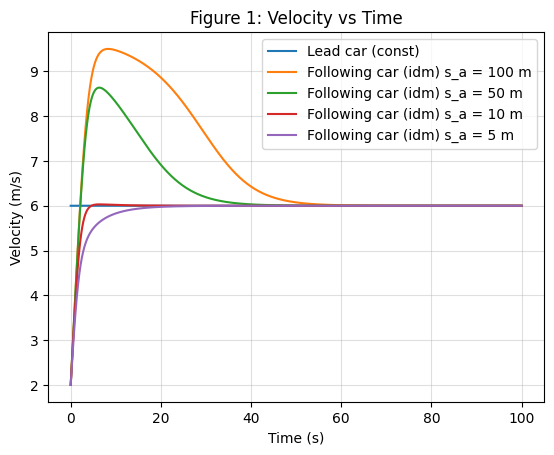

In [35]:
# s_a - initial distance
plt.figure()
plt.title('Figure 1: Velocity vs Time')

plt.plot(t_list, [V_CAR_1] * len(t_list), label = 'Lead car (const)')

i = 0
for gap in gaps:
    plt.plot(t_list, data[i]['vF'], label = f'Following car (idm) s_a = {gap} m')
    i+=1
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

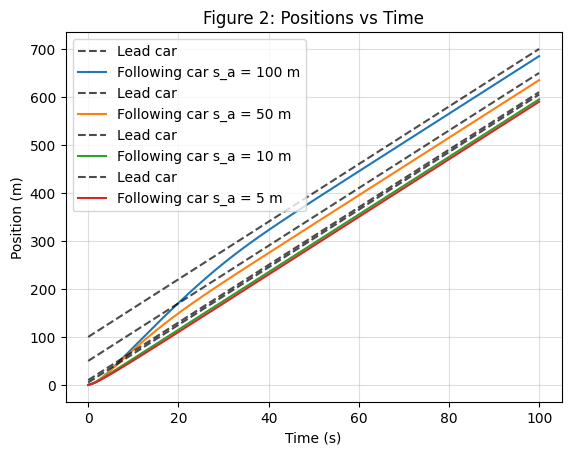

In [36]:
plt.figure()
plt.title('Figure 2: Positions vs Time')

i = 0
for gap in gaps:
    car_1_position = gap + V_CAR_1 * t_list
    plt.plot(t_list, car_1_position, color='0', label = f'Lead car', alpha=0.7, linestyle='--')
    plt.plot(t_list, data[i]['xF'], label = f'Following car s_a = {gap} m')
    i+=1

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.grid(True, alpha=0.4)
plt.show()

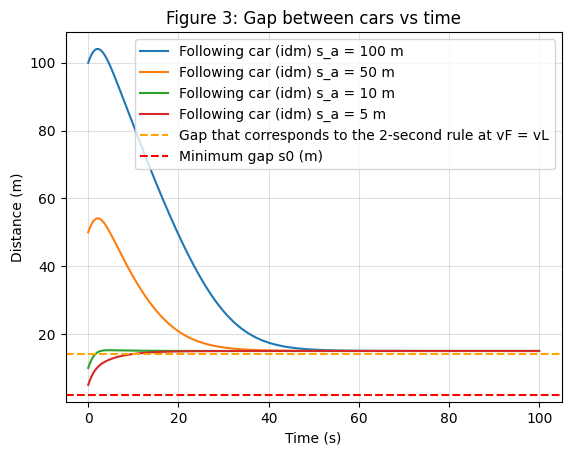

In [37]:
plt.figure()
plt.title('Figure 3: Gap between cars vs time')

i = 0
for gap in gaps:
    plt.plot(data[i]['t'], data[i]['gap'], label = f'Following car (idm) s_a = {gap} m')
    i+=1

plt.axhline(y=S_MIN + SAFE_TIME_HEADWAY * V_CAR_1, color='orange', linestyle='--', label = 'Gap that corresponds to the 2-second rule at vF = vL')
plt.axhline(y=S_MIN, color='r', linestyle='--', label = 'Minimum gap s0 (m)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.grid(True, alpha=0.4)
plt.show()

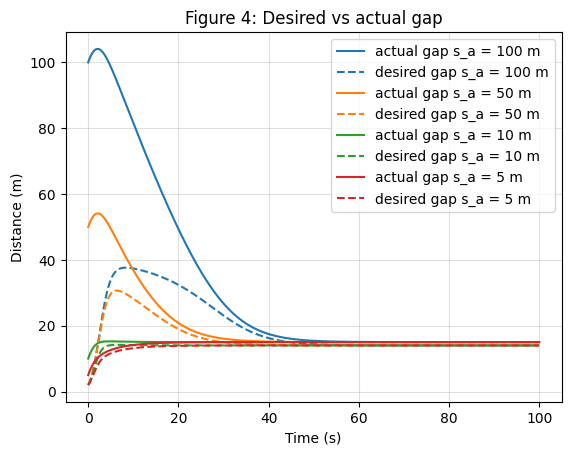

In [38]:
plt.figure()
plt.title('Figure 4: Desired vs actual gap')
i = 0
for gap in gaps:
    plt.plot(data[i]['t'], data[i]['gap'], color=f'C{i}', label = f'actual gap s_a = {gap} m')
    plt.plot(data[i]['t'], data[i]['s_star'], color=f'C{i}', linestyle='--', label = f'desired gap s_a = {gap} m')
    i+=1
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.grid(True, alpha=0.4)
plt.show()

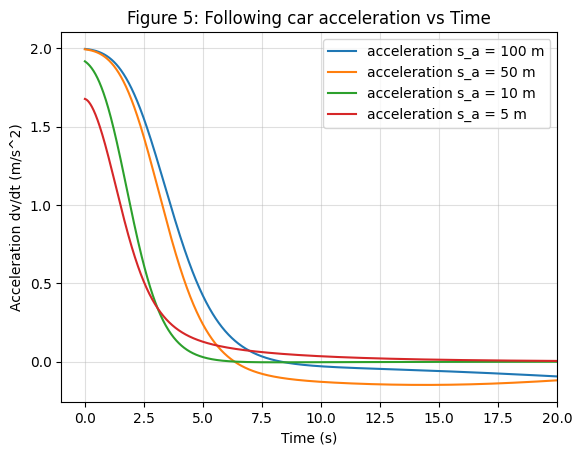

In [39]:
plt.figure()
plt.title('Figure 5: Following car acceleration vs Time')
i = 0
for gap in gaps:
    plt.plot(data[i]['t'][:-1], data[i]['aF'], label = f'acceleration s_a = {gap} m')
    i+=1
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Acceleration dv/dt (m/s^2)')
plt.grid(True, alpha=0.4)
plt.xlim(-1, 20)
plt.show()

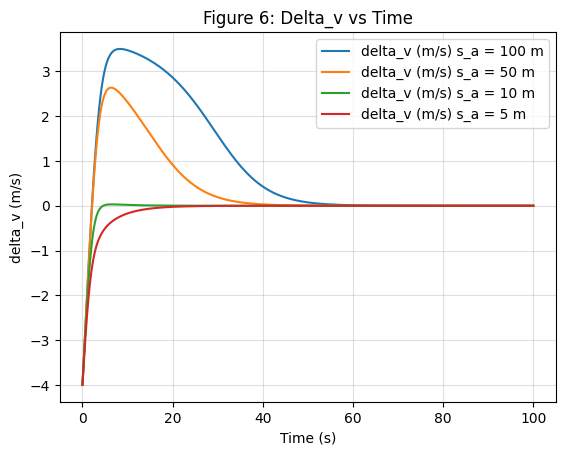

In [40]:
plt.figure()
plt.title('Figure 6: Delta_v vs Time')
i = 0
for gap in gaps:
    plt.plot(data[i]['t'], data[i]['delta_v'], label = f'delta_v (m/s) s_a = {gap} m')
    i+=1
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('delta_v (m/s)')
plt.grid(True, alpha=0.4)
plt.show()

### Honest limitations

1. Numerical/Performance: Euler method may introduce error if the step size is not small enough. Also, the Euler method is not the most efficient at performing large calculations.

2. Physical: the model ignores multiple physical space variables like potential potholes, speed bumps, lane changes.

3. Variable values: not all initial constant values are chosen based on specific real world scenarios, instead they are selected by me. I tried limiting my human error/bias by consulting actual car drivers and previous models designed by other researchers.

### Conclusion

This computational essay explored the Intelligent Driver Model (IDM) for a simple two-car scenario where overtaking is not allowed. Across different initial gaps, the follower adjusts acceleration based on the difference between the actual gap $s(t)$ and the desired gap $s^*(t)$. Over time, the follower’s speed converges to the leader’s speed $\Delta v$ -> $0$, and the headway settles near $s(t) = s_0 + v * T$.

The main takeaway is that the small gaps trigger earlier braking, while large gaps allow an initial acceleration phase before settling.

### Next steps

As this essay is exploratory in nature it is important to identify what are future research areas that would improve the understanding of driver behaviour.

1. Introducing more cars: it would be beneficial to understand if introduction of more cars will create braking shockwaves. (This is something I tried examining in the `original_topic.ipynb` file. Note, that it does not use IDM - something I will adapt in the future).

2. Introduction of lane-changing behaviour. Cars in the real world behave extremely differently because roads usually exist in a 2D space with 2+ traffic lanes.

3. Calibration of data parameters: as discussed in the *limitation* section, the model real world accuracy could significantly increase if all parameters are chosen from relevant academic studies.

4. Replacing the Euler Method: if improvements above are implemented, the Euler method can function as a bottleneck limiting performance. It could be replaced by a Runge-Kutta method.